In [1]:
# !pip install --user brainreg

In [2]:
!if [ ! -d ~/.brainglobe ]; then mkdir ~/.brainglobe; fi
!if [ ! -d ~/.brainglobe/allen_mouse_25um_v1.2 ]; then ln -s /bil/workshops/2022/data_submission/july/allen_mouse_25um_v1.2 ~/.brainglobe/allen_mouse_25um_v1.2; fi

In [3]:
from glob import glob
import json
import os
from pathlib import Path

from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import bg_space as bgs
import dask
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import tifffile

plt.rcParams['figure.figsize'] = [15, 15]

In [4]:
home = Path.home()
print(home)

/bil/users/noisysky


In [5]:
atlas = BrainGlobeAtlas('allen_mouse_25um')

## Step 1: Downsample full resolution image

Path to example dataset. We need red channel for the alignment purposes, which is Channel 2.

In [6]:
fmost_orig_path = "/bil/data/df/75/df75626840c76c15/mouseID_373187-191817"

In [7]:
ch2_path = os.path.join(fmost_orig_path, 'CH2')

We'll save intermediate downsampled files to our home directory

In [8]:
ch2_resampled_path = home / 'tmp' / 'resampled'
if not os.path.exists(str(ch2_resampled_path)):
    os.makedirs(str(ch2_resampled_path))

Let's find out how many files (individually imaged slices) we have

In [9]:
files_ch2 = sorted(glob(os.path.join(ch2_path, '*.tif')))  # 2D images in the coronal plane
shape_ap = len(files_ch2)
shape_ap

11428

From the configuration json file, we can get shape and resolution of images

In [2]:
!cat /bil/data/df/75/df75626840c76c15/mouseID_373187-191817/191817.json

{
	"SampleInfo":{
		"SampleID":"191817",
		"DataSize":4.64,
		"VoxelResolution ":[0.35,0.35,1],
		"Layer":11428,
		"Layer_satrt_end":[1,11428],
		"Rotation":0,
		"ImageSize":[19906,29401],
		"ImagingChannel":["GFP","PI"]
	},
	"SourceInfo":{
		"SourceID":"373187",
		"SampleSource":"HongkuiZENG"
	},
	"FolderInfo":{
		"montage":{"VoxelResolution":[0.35,0.35,1]},
		"projection":{"VoxelResolution":[0.35,0.35,100]},
		"resample":{"VoxelResolution":[3.5,3.5,1]},
		"projection_res":{"VoxelResolution":[3.5,3.5,100]}
	}
}

In [10]:
setup = {}
with open(os.path.join(fmost_orig_path, '191817.json')) as f:
    setup_str = f.read()
    setup = json.loads(setup_str)

shape_si, shape_rl = setup['SampleInfo']['ImageSize']
print(shape_si, shape_rl)

19906 29401


In [11]:
resolution_si, resolution_rl, resolution_ap = setup['SampleInfo']['VoxelResolution ']
print(resolution_ap, resolution_rl, resolution_si)

1 0.35 0.35


We can calculate how big is the brain in physical units (microns)

In [12]:
img_size_um = (shape_rl * resolution_rl, float(shape_ap * resolution_ap), shape_si * resolution_si)  # right-to-left, anterior-to-posterior, superior-to-inferior
print(img_size_um)

(10290.349999999999, 11428.0, 6967.099999999999)


We'll downsample the image to 25 micron voxel spacing. The new shape of the 3D image stack will be:

In [13]:
downsampled_shape = tuple((int(np.round(float(x) / y)) for x, y in zip(img_size_um, atlas.resolution)))
print(downsampled_shape)

(412, 457, 279)


Usually we don't have enough RAM to read the whole multi-terabyte dataset and downsample it in-memory. <br/>
Therefore, we first downsample each 2D image plane (stored as separate tiff file). <br/>
This step takes very long. Files that are already downsampled are ignored if you re-run the function several times.

In [14]:
img0 = tifffile.imread(files_ch2[0])

def resize_lateral_sequential(files, si_shape, rl_shape):
    files = [f for f in files if not os.path.exists(os.path.join(ch2_resampled_path, os.path.basename(f)))]
    for file in files:
        img_downsampled = resize(tifffile.imread(file).astype(np.float32), (rl_shape, si_shape), anti_aliasing=True)
        tifffile.imwrite(os.path.join(str(ch2_resampled_path), os.path.basename(file)), img_downsampled.astype(img0.dtype))


def resize_lateral_parallel(files, si_shape, rl_shape):
    files = [f for f in files if not os.path.exists(os.path.join(ch2_resampled_path, os.path.basename(f)))]
    print("Files to resize:", len(files))

    def read_img(file):
        print('reading', file)
        return tifffile.imread(file)
    
    def resize_img(img):
        return resize(img.astype(np.float32), (rl_shape, si_shape), anti_aliasing=True)
    
    def save_img(img, file):
        print('saving', file)
        tifffile.imwrite(os.path.join(str(ch2_resampled_path), os.path.basename(file)), img.astype(img0.dtype))
        return True
    
    imgs = [dask.delayed(read_img)(i) for i in files]
    resized = [dask.delayed(resize_img)(i) for i in imgs]
    saved = [dask.delayed(save_img)(i, f) for i, f in zip(resized, files)]
    saved = dask.compute(saved)

In [15]:
resize_lateral_parallel(files_ch2, downsampled_shape[2], downsampled_shape[0])

Files to resize: 0


After downsampling and saving individual files (layers), we need to downsample in the remaining third dimension. This we can do in-memory:

In [16]:
downsampled_files = sorted(glob(os.path.join(str(ch2_resampled_path), '*.tif')))
downsampled_stack = np.empty((shape_ap, downsampled_shape[0], downsampled_shape[2]), dtype=img0.dtype)
print(downsampled_stack.shape)

(11428, 412, 279)


In [17]:
def read_downsampled_stack_sequential(files):
    for i, file in enumerate(downsampled_files):
        downsampled_stack[i, :, :] = tifffile.imread(file)

def read_downsampled_stack_parallel(files):
    def read_img(file):
        return tifffile.imread(file)
    
    def save_img(ind, img):
        downsampled_stack[ind, :, :] = img
        return True
    
    imgs = [dask.delayed(read_img)(f) for f in files]
    saved = [dask.delayed(save_img)(i, f) for i, f in enumerate(imgs)]
    saved = dask.compute(saved)

In [18]:
read_downsampled_stack_parallel(downsampled_files)

In [19]:
downsampled_stack = resize(downsampled_stack, (downsampled_shape[1], downsampled_shape[0], downsampled_shape[2]), anti_aliasing=True)
print(downsampled_stack.shape)

(457, 412, 279)


Let's save the downsampled stack:

In [20]:
tifffile.imwrite(str(home / 'tmp' / 'fMOST_example_25um_isotropic_ARS.tif'), (downsampled_stack * np.iinfo(img0.dtype).max).astype(img0.dtype))

And let's inspect it visually, to tell what orientation it was imaged in. <br/>
Orientation is composed of 3 letters that specify data origin. For example, atlas orientation is **"asr"** (for anterior - superior - right)

First dimension are coronal slices, which go from anterior to posterior, so first letter of orientaion is "a" (anterior)

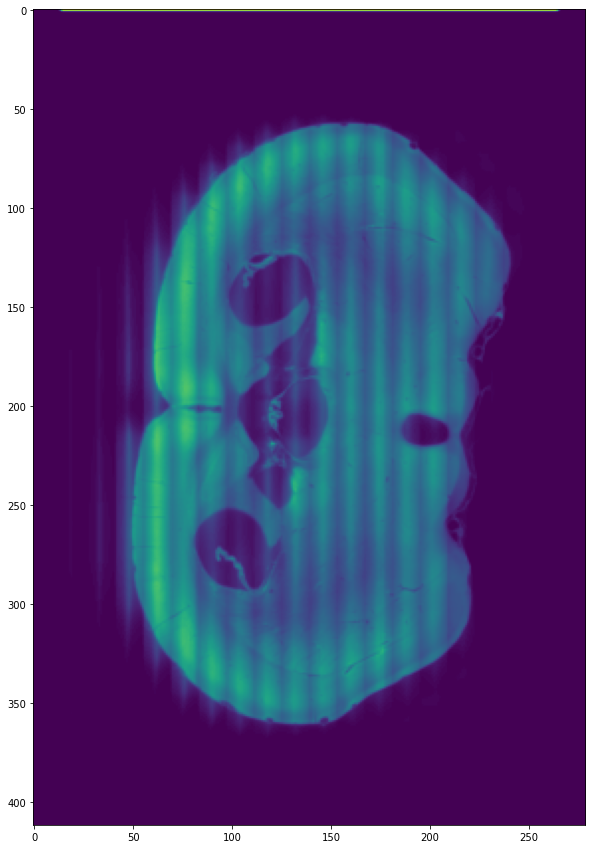

In [21]:
plt.imshow(downsampled_stack[200, :, :])

Second dimension are sagittal slices that go from right to left edge of the brain, so the second letter in orientation is "r" (right)

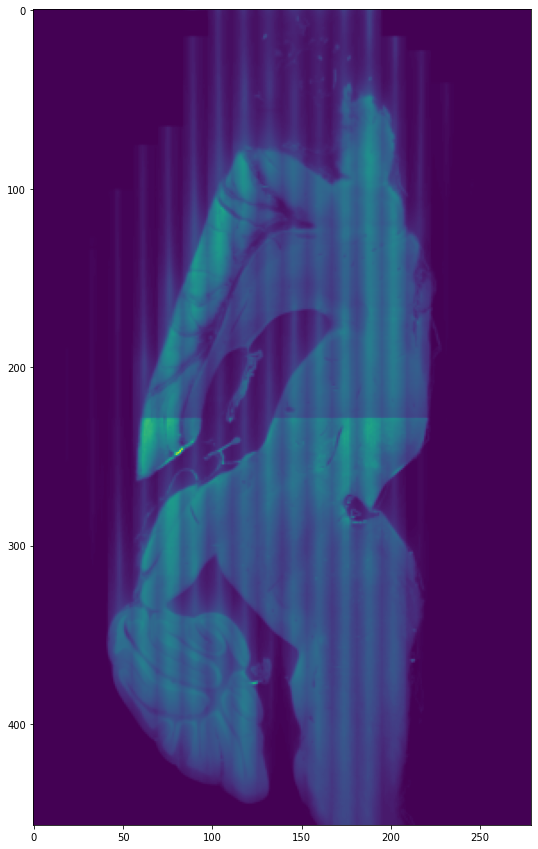

In [22]:
plt.imshow(downsampled_stack[:, 200, :])

Last, third dimension are horizontal slices that go from superior to inferior, so the last letter in the orientation is "s" (superior).

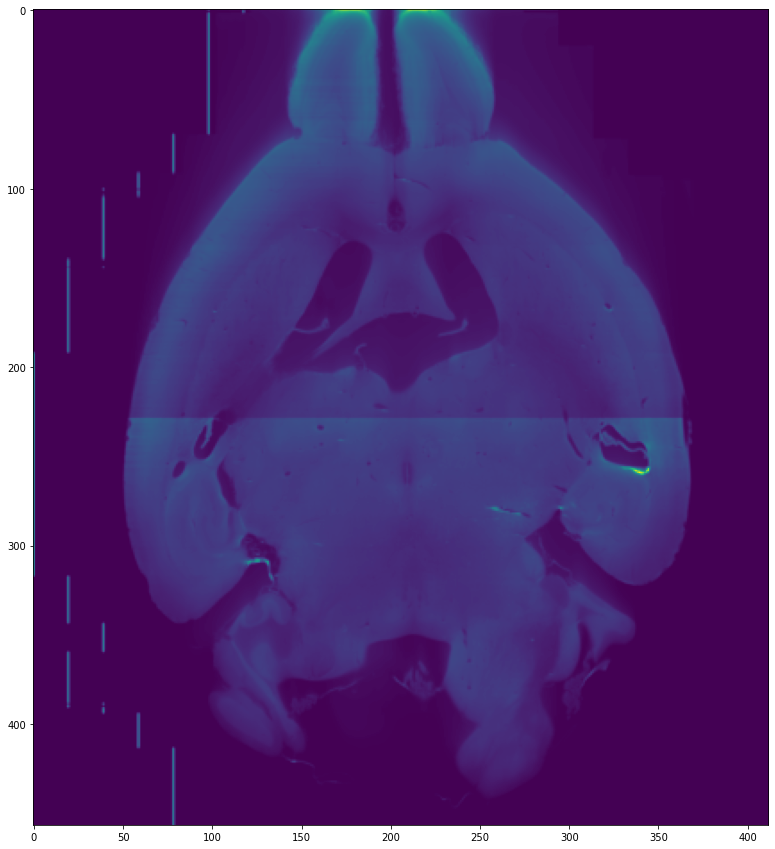

In [23]:
plt.imshow(downsampled_stack[:, :, 140])

We got the orientation "ars" for our dataset. <br/>
Now we can check whether we got it correct, by reorienting our stack to atlas orientation. <br/>
If after reorienting, our stack looks same as atlas (in terms of orientation) then the indicated orientation ("ars" in our case) is correct.

In [24]:
downsampled_stack = bgs.map_stack_to('ars', atlas.orientation, downsampled_stack)

In [25]:
print(downsampled_stack.shape)

(457, 279, 412)


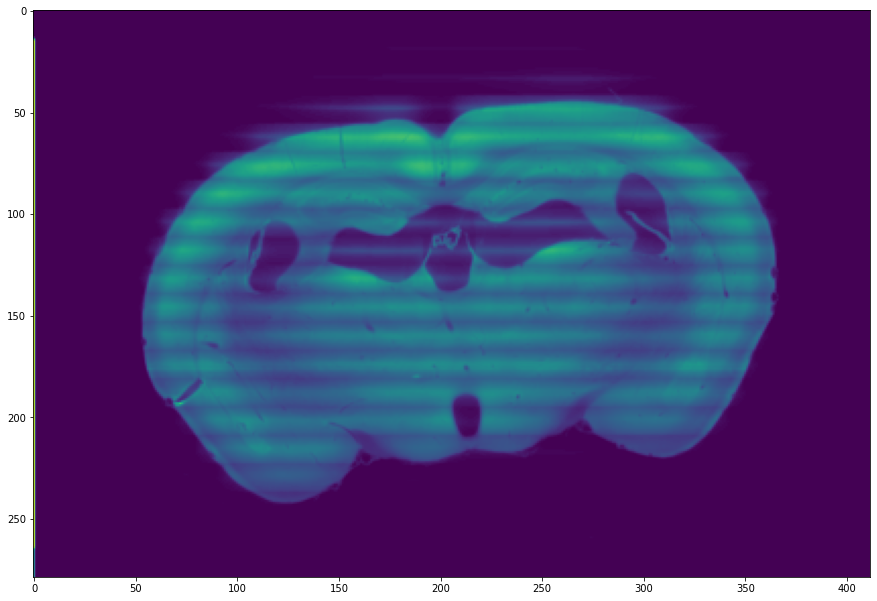

In [26]:
plt.imshow(downsampled_stack[220, :, :])